In [ ]:
## Introduction and Problem Statement: 
### Objective: 
Predict whether a loan applicant is likely to default on a loan (loan_paid_back = 0) or pay it back (loan_paid_back = 1).
### Problem Statement:
In finance, accurately assessing credit risk is crucial to prevent financial losses and ensure sustainable lending. 
This task utilizes historical loan data to build a classification model capable of distinguishing high-risk applicants (likely to default) from 
low-risk applicants. We prioritize **Recall** for the default class (class 0) to minimize False Negatives (approving a loan that defaults).

In [1]:
# --- Setup and Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Suppress all warnings for clean notebook execution
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visualization style
sns.set_style("whitegrid")

In [3]:
# --- Data Loading and Initial Inspection ---

try:
    df = pd.read_csv('Loan-Data.csv')
    print("Dataset 'Loan-Data.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'Loan-Data.csv' not found. Please ensure the file is in the same directory.")
    exit()

# Initial Inspection
print("\n--- Dataset Initial Inspection ---")
print(f"Dataset Shape: {df.shape}")
print(df.head())

Dataset 'Loan-Data.csv' loaded successfully.

--- Dataset Initial Inspection ---
Dataset Shape: (20000, 22)
   age  gender marital_status education_level  annual_income  monthly_income  \
0   59    Male        Married        Master's       24240.19         2020.02   
1   72  Female        Married      Bachelor's       20172.98         1681.08   
2   49  Female         Single     High School       26181.80         2181.82   
3   35  Female         Single     High School       11873.84          989.49   
4   63   Other         Single           Other       25326.44         2110.54   

  employment_status  debt_to_income_ratio  credit_score  loan_amount  ...  \
0          Employed                 0.074           743     17173.72  ...   
1          Employed                 0.219           531     22663.89  ...   
2          Employed                 0.234           779      3631.36  ...   
3          Employed                 0.264           809     14939.23  ...   
4          Employed       

In [4]:
# --- Data Cleaning: Missing Value Check and Feature Removal ---

print("\n--- Missing Value Check ---")
missing_values = df.isnull().sum().sum()
if missing_values == 0:
    print("No missing values found. Data is clean.")
else:
    print(f"Total missing values: {missing_values}. Handling required.")


--- Missing Value Check ---
No missing values found. Data is clean.


In [5]:
# Dropping 'monthly_income' as it is highly correlated with 'annual_income', preventing multicollinearity

df = df.drop('monthly_income', axis=1)
print(f"Dropped 'monthly_income'. New Dataset Shape: {df.shape}")

Dropped 'monthly_income'. New Dataset Shape: (20000, 21)


In [ ]:
## Exploratory Data Analysis (EDA) with Graphs

### Objective: Visualize key features: loan amount, education, and income.


--- Generating Visualizations ---


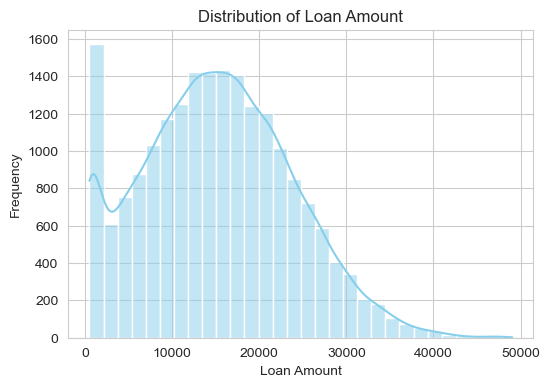

In [15]:
print("\n--- Generating Visualizations ---")

# Loan Amount Distribution (Histogram)
# Provides insight into the typical size of loans issued.  

plt.figure(figsize=(6, 4))
sns.histplot(df['loan_amount'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

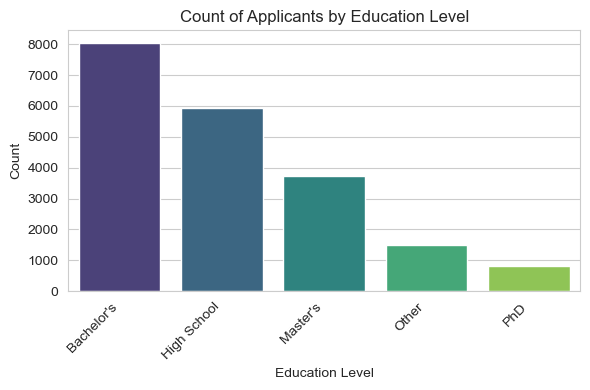

In [16]:
# Education Status (Bar Plot)
# Shows the frequency count of loan applicants based on their education level.  

plt.figure(figsize=(6, 4))
education_order = df['education_level'].value_counts().index
sns.countplot(x='education_level', data=df, order=education_order, palette='viridis')
plt.title('Count of Applicants by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

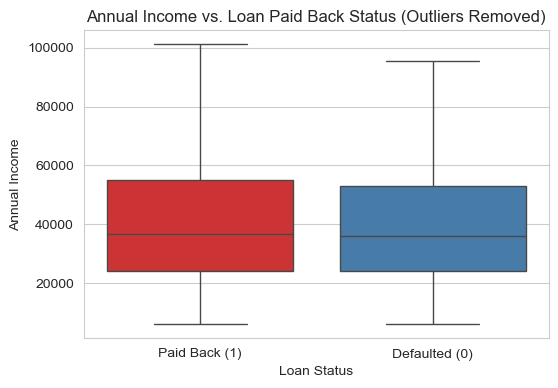

In [17]:
# Annual Income vs. Loan Status (Box Plot)
# Compares the distribution of annual income between defaulted and paid-back loans. 

df['Loan_Status_Label'] = df['loan_paid_back'].apply(lambda x: 'Paid Back (1)' if x == 1 else 'Defaulted (0)')
plt.figure(figsize=(6, 4))

# 'showfliers=False' is used to remove outliers for cleaner visualization of the main income distribution

sns.boxplot(x='Loan_Status_Label', y='annual_income', data=df, palette='Set1', showfliers=False)
plt.title('Annual Income vs. Loan Paid Back Status (Outliers Removed)')
plt.xlabel('Loan Status')
plt.ylabel('Annual Income')
plt.show()
df = df.drop('Loan_Status_Label', axis=1) # Drop helper column

In [ ]:
## 4. Data Preparation for Modeling

### Steps:
1.  Separate features ($\mathbf{X}$) and target ($\mathbf{y}$).
2.  Apply **One-Hot Encoding** to convert categorical variables into numerical format.
3.  Split the data into training ($\mathbf{80\%}$) and testing ($\mathbf{20\%}$) sets.

In [19]:
# Separate Features and Target

X = df.drop('loan_paid_back', axis=1) # All columns except the target are features
y = df['loan_paid_back']            # The target variable

In [20]:
# One-Hot Encoding for categorical features
# drop_first=True prevents the multicollinearity dummy variable trap.

X_encoded = pd.get_dummies(X, drop_first=True)


In [21]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"\nTraining set shape (X_train): {X_train.shape}")
print(f"Testing set shape (X_test): {X_test.shape}")


Training set shape (X_train): (16000, 63)
Testing set shape (X_test): (4000, 63)


In [ ]:
## Model Training and Testing

### Model: Logistic Regression
Logistic Regression is used as a baseline classification model. 
The parameter $\mathbf{class\_weight='balanced'}$ is vital here to automatically adjust weights inversely proportional to class frequencies, 
effectively prioritizing the correct identification of the minority class (Defaults), which is essential for credit risk.

In [22]:
# Train Model with Class Weighting
# solver='liblinear' is good for small datasets and binary classification.
# class_weight='balanced' is used to handle the imbalanced nature of the dataset.
logreg_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
print("\nTraining Logistic Regression model...")
logreg_model.fit(X_train, y_train)
print("Training complete.")

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)


Training Logistic Regression model...
Training complete.


In [ ]:
## Evaluation Metrics

### Objective: Evaluate model using accuracy and a confusion matrix.
Evaluation focuses on (Recall) for class 0 (Default) as it measures the model's ability to detect high-risk cases.


--- Model Evaluation (Logistic Regression with Balanced Weights) ---
Accuracy Score: 0.8133

Confusion Matrix:
[[ 600  218]
 [ 529 2653]]

Classification Report (for class '0' - Defaulted, and class '1' - Paid Back):

              precision    recall  f1-score   support

           0       0.53      0.73      0.62       818
           1       0.92      0.83      0.88      3182

    accuracy                           0.81      4000
   macro avg       0.73      0.78      0.75      4000
weighted avg       0.84      0.81      0.82      4000



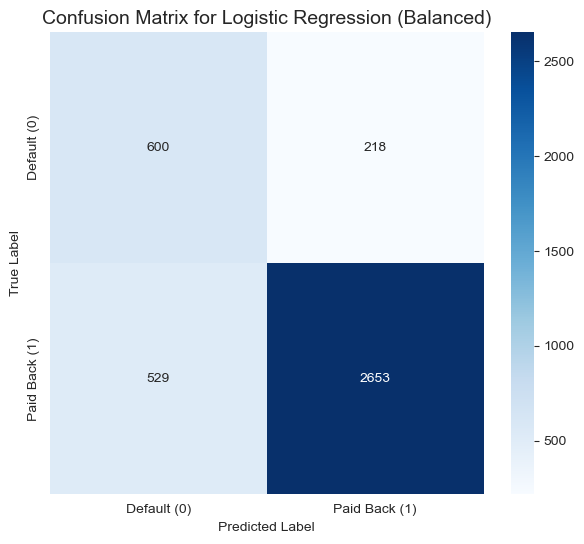

In [23]:
# --- Model Evaluation ---

print("\n--- Model Evaluation (Logistic Regression with Balanced Weights) ---")

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
report = classification_report(y_test, y_pred)
print("\nClassification Report (for class '0' - Defaulted, and class '1' - Paid Back):\n")
print(report)

# Visualize the Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Default (0)', 'Paid Back (1)'],
    yticklabels=['Default (0)', 'Paid Back (1)']
)
plt.title('Confusion Matrix for Logistic Regression (Balanced)', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
### Conclusion Summarizing Key Insights
## 1. Risk Mitigation Priority: The model is successful at its primary job: catching high-risk customers. It correctly identifies 73% of all defaulters (Recall), which is critical for preventing financial losses (minimizing False Negatives).
## 2. Necessary Trade-off: This caution means the model is sometimes overly strict, incorrectly flagging good customers as risky (53% Precision for defaults). In credit risk, this trade-off (accepting missed opportunities) is preferred over taking on a bad loan.
## 3. Model Strength: It is highly accurate in predicting safe loans, with 92% Precision for customers who pay back.